In [1]:
import numpy as np
import os
import cv2
import json
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
from tqdm.notebook import tqdm

In [2]:
def imshow(image):
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.imshow(image)


def draw_boxes_cv2(image, boxes, categories):
    boxes = np.array(boxes, dtype=np.int32)
    for _box, _cls in zip(boxes, categories):
        text = _cls
        char_len = len(text) * 9
        text_orig = (_box[0] + 5, _box[1] - 6)
        text_bg_xy1 = (_box[0], _box[1] - 20)
        text_bg_xy2 = (_box[0] + char_len, _box[1])
        image = cv2.rectangle(image, text_bg_xy1, text_bg_xy2, [255, 252, 150],
                              -1)
        image = cv2.putText(image,
                            text,
                            text_orig,
                            cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            .6, [0, 0, 0],
                            5,
                            lineType=cv2.LINE_AA)
        img = cv2.putText(image,
                          text,
                          text_orig,
                          cv2.FONT_HERSHEY_COMPLEX_SMALL,
                          .6, [255, 255, 255],
                          1,
                          lineType=cv2.LINE_AA)
        img = cv2.rectangle(image, (_box[0], _box[1]), (_box[2], _box[3]),
                            [30, 15, 30], 1)
    return img


def convert_box(box, out_format):
    assert out_format in ['xywh', 'x1y1x2y2'], 'Invalid box format'

    if out_format == 'xywh':
        x1, y1, x2, y2 = box
        x = (x1 + x2) / 2
        y = (y1 + y2) / 2
        w = (x2 - x1)
        h = (y2 - y1)
        return [x, y, w, h]

    x, y, w, h = box
    x1 = x - (w / 2)
    y1 = y - (h / 2)
    x2 = x + (w / 2)
    y2 = y + (h / 2)
    return [x1, y1, x2, y2]

In [3]:
def draw_circle(rgb_canvas, trials=1):
    if trials > 100:
        return rgb_canvas
    H, W = rgb_canvas.shape[:2]

    canvas = np.uint8(~np.all(rgb_canvas == [255, 255, 255], axis=-1))

    max_radius = 0.20 * int(np.sqrt(H * W))
    min_radius = 0.05 * int(np.sqrt(H * W))

    radius = int(np.random.randint(low=min_radius, high=max_radius))

    x = int(np.random.randint(low=radius + 1, high=(W - radius - 1)))
    y = int(np.random.randint(low=radius + 1, high=(H - radius - 1)))

    new_canvas = np.zeros_like(canvas)
    new_canvas = cv2.circle(new_canvas,
                            center=(x, y),
                            radius=radius,
                            color=1,
                            thickness=-1)

    if np.any(np.logical_and(new_canvas, canvas)):
        return draw_circle(rgb_canvas, trials=trials + 1)

    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]
    color = list(colors[np.random.randint(0, 3)])

    x1, y1, x2, y2 = map(
        int, convert_box([x, y, 2 * radius, 2 * radius], out_format='x1y1x2y2'))

    return cv2.circle(rgb_canvas,
                      center=(x, y),
                      radius=radius,
                      color=color,
                      thickness=-1), {
                          'box': [x1, y1, x2, y2],
                          'category': 'circle'
                      }


def draw_rectangle(rgb_canvas, trials=0):
    if trials > 100:
        return canvas

    canvas = np.uint8(~np.all(rgb_canvas == [255, 255, 255], axis=-1))

    H, W = canvas.shape[:2]
    smaller_side = min(H, W)

    min_dim = 0.15 * smaller_side
    max_dim = 0.6 * smaller_side

    h = int(np.random.randint(low=min_dim, high=max_dim)) / 2
    w = int(np.random.randint(low=min_dim, high=max_dim)) / 2

    x = int(np.random.randint(low=w + 1, high=(W - w - 1)))
    y = int(np.random.randint(low=h + 1, high=(H - h - 1)))
    x1, y1, x2, y2 = map(int, convert_box([x, y, w, h], out_format='x1y1x2y2'))

    new_canvas = np.zeros_like(canvas)
    new_canvas = cv2.rectangle(new_canvas,
                               pt1=(x1, y1),
                               pt2=(x2, y2),
                               color=1,
                               thickness=-1)

    if np.any(np.logical_and(new_canvas, canvas)):
        return draw_rectangle(rgb_canvas, trials=trials + 1)

    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]
    color = list(colors[np.random.randint(0, 3)])

    return cv2.rectangle(rgb_canvas,
                         pt1=(x1, y1),
                         pt2=(x2, y2),
                         color=color,
                         thickness=-1), {
                             'box': [x1, y1, x2, y2],
                             'category': 'rectangle'
                         }

In [4]:
def create_dataset(num_samples,
                   image_shape,
                   max_objects=6,
                   draw_fns=[draw_circle, draw_rectangle],
                   save_dir=None):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        os.mkdir(os.path.join(save_dir, 'images'))
    elif not os.path.exists(os.path.join(save_dir, 'images')):
        os.mkdir(os.path.join(save_dir, 'images'))

    dataset = {}

    for i in tqdm(range(num_samples)):
        image_name = '{}.png'.format(i)
        objects = []
        image_path = os.path.join(save_dir, 'images', image_name)
        rgb_canvas = np.ones(shape=[h, w, 3], dtype=np.uint8) * 255
        num_objects = np.random.randint(low=1, high=max_objects + 1)

        for i in range(num_objects):
            fn = np.random.choice(draw_fns)
            canvas, annotation = fn(rgb_canvas)
            objects.append(annotation)

        imsave(image_path, rgb_canvas, check_contrast=False)
        dataset[image_name] = objects
        
    with open(os.path.join(save_dir, 'dataset.json'), 'w') as fp:
        json.dump(dataset, fp, indent=4)
    return dataset

In [5]:
h, w = 448, 448
num_samples = 3000
dataset = create_dataset(num_samples, [h, w], max_objects=5, save_dir='../tutorials/data/shapes_dataset')

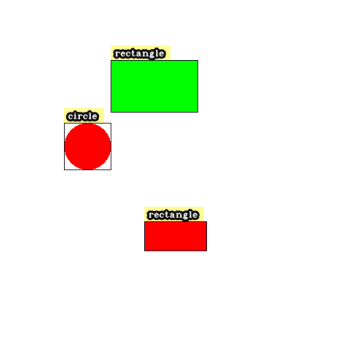

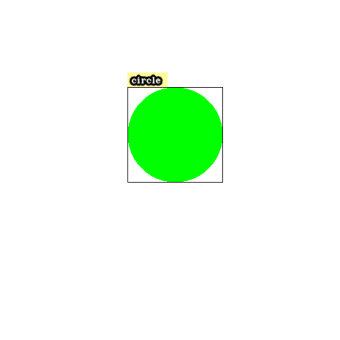

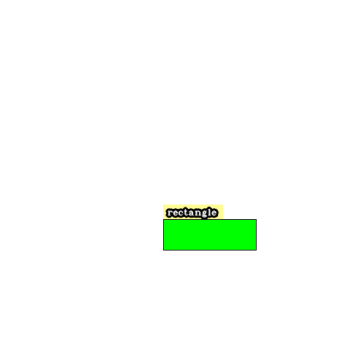

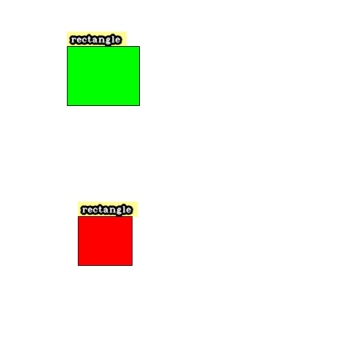

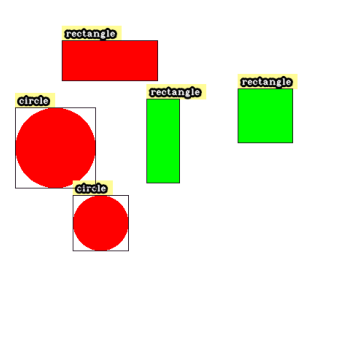

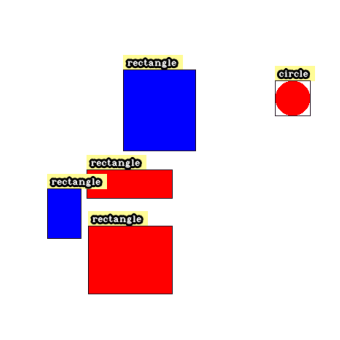

In [6]:
for i, (image_path, annotation) in enumerate(dataset.items()):
    boxes = []
    categories = []
    for obj in annotation:
        boxes.append(obj['box'])
        categories.append(obj['category'])
        
    image = imread('../tutorials/data/shapes_dataset/images/' + image_path)
    image = draw_boxes_cv2(image, boxes, categories)
    imshow(image)
    if i == 5: break